# Reservoir volume - GloFAS5
***

**Author**: Chus Casado Rodríguez<br>
**Date**: 04-03-2025<br>

**Introduction**<br>

This notebook creates a map (in GeoTIFF format) of reservoir volume that will be used to create the layer *Reservoir impact* in the GloFAS Web Viewer.

In [42]:
import os
os.environ['USE_PYGEOS'] = '0'
import rioxarray as rxr
import pandas as pd
import geopandas as gpd
from shapely import Point
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from datetime import datetime

In [37]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Configuration

In [51]:
PATH_USER = Path('Z:/nahaUsers/casadje')
PATH_GLOFAS5 = PATH_USER / 'GloFASv5' / 'reservoirs' / 'tables'
PATH_GLOFAS4 = PATH_USER / 'GloFASv4'

## Reservoir table

Reservoir file: Z:\nahaUsers\casadje\GloFASv5\reservoirs\tables\glofas5_reservoirs_20250228.xlsx
1710 reservoirs


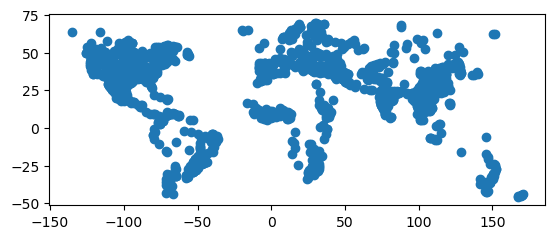

In [43]:
idx_name = 'GDW_ID'

# read table of reservoirs
res_file = list(PATH_GLOFAS5.glob('glofas5_reservoirs*.xlsx'))[-1]
print(f'Reservoir file: {res_file}')
reservoirs = pd.concat([pd.read_excel(res_file, sheet_name=sheet, index_col=idx_name) for sheet in ['as_reservoirs', 'as_lakes']], axis=0).sort_index()
reservoirs = reservoirs.loc[reservoirs.index.notnull()]
reservoirs.index = reservoirs.index.astype(int)

# convert to geopandas
reservoirs = gpd.GeoDataFrame(
    data=reservoirs,
    geometry=[Point(xy) for xy in zip(reservoirs.LisfloodX, reservoirs.LisfloodY)],
    crs='epsg:4326'
)

print('{0} reservoirs'.format(len(reservoirs)))

reservoirs.plot();

### Map of reservoir volume

In [49]:
# load map from GloFAS4
mapa = rxr.open_rasterio(PATH_GLOFAS4 / 'static_maps' / '20220802_reservoirs_Global_03min.nc')#.squeeze(dim='band').astype(int)
mapa.close()
mapa.name = 'volume'

# remove all lakes
mapa[:,:] = np.nan

# assign IDs of lakes in GloFAS5
for ID, row in tqdm(reservoirs.iterrows(), total=len(reservoirs)):
    pixel = mapa.sel({'x': row.LisfloodX, 'y': row.LisfloodY}, method='nearest')
    mapa.loc[{'x': pixel.x.item(), 'y': pixel.y.item()}] = reservoirs.loc[ID, 'CAP_MCM'] * 1e6

# modify attributes
mapa.attrs['contributors'] = 'Juliana Disperati <juliana.disperati@ext.ec.europa.eu>'
mapa.attrs['creator'] = 'Jesús Casado Rodríguez <jesus.casado-rodriguez@ec.europa.eu>'
mapa.attrs['creator_name'] = 'casadje'
mapa.attrs['history'] = ('Created {0}'.format(datetime.now().strftime("%a %b %e %H:%M:%S %Y")))
mapa.attrs['history_of_appended_files'] = ''
mapa.attrs['institution'] = 'Joint Research Centre - European Commission'
mapa.attrs['references'] = 'https://www.globaldamwatch.org/grand'
mapa.attrs['long_name'] = 'reservoir_volume'
mapa.attrs['units'] = 'm3'

# define coordinate reference system
mapa = mapa.rio.write_crs('EPSG:4326')

  0%|          | 0/1710 [00:00<?, ?it/s]

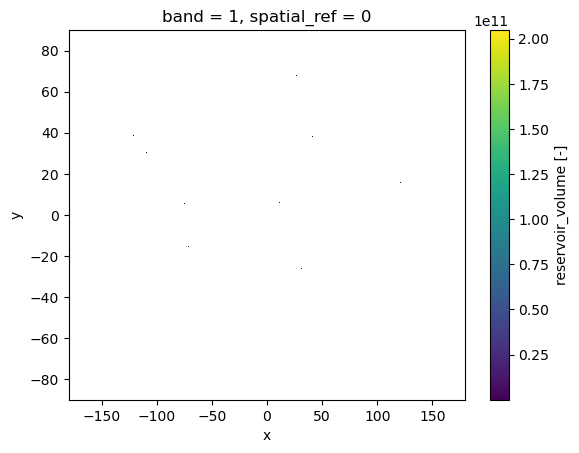

In [45]:
mapa.plot();

In [55]:
# export as GeoTIFF
tiff_file = PATH_GLOFAS5 / 'reservoirs_glofas5_volume_m3_{0}.tiff'.format(datetime.now().strftime('%Y%m%d'))
mapa.rio.to_raster(tiff_file)
print(f'Map of reservoir volume saved in {tiff_file}')

Map of reservoir volume saved in Z:\nahaUsers\casadje\GloFASv5\reservoirs\tables\reservoirs_glofas5_volume_m3_20250304.tiff
